In [2]:
import sys
curr_dir = '/user_data/vayzenbe/GitHub_Repos/bwoc'
sys.path.insert(0, curr_dir)
import pandas as pd
from nilearn import image, plotting, input_data, glm, maskers
#from nilearn.glm import threshold_stats_img
import numpy as np


import nibabel as nib
from nilearn.maskers import NiftiSpheresMasker, NiftiMasker

import os
import statsmodels.api as sm
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template
import matplotlib.pyplot as plt
import pdb
from scipy.stats import gamma
import warnings

import bwoc_params as params

warnings.filterwarnings('ignore')

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [3]:
sub_list = params.sub_info

In [12]:
for loc_sub,erd_sub in zip(sub_list['loc_sub'], sub_list['erd_sub']):
    #if sub doesn't exist, skip
    if loc_sub.is == np.nan or erd_sub == np.nan:
        print('skipping', loc_sub, erd_sub)
    else:
        print(loc_sub, erd_sub)

spaceloc1001 docnet2001
spaceloc1002 docnet2002
spaceloc1003 docnet2003
spaceloc1004 docnet2004
spaceloc1005 docnet2005
spaceloc1006 nan
spaceloc1007 docnet2007
spaceloc1008 docnet2008
spaceloc1009 nan
spaceloc1010 nan
spaceloc1011 nan
spaceloc1012 docnet2012
spaceloc2013 docnet2013
spaceloc2014 docnet2014
spaceloc2015 docnet2015
spaceloc2016 docnet2016
spaceloc2017 docnet2017
spaceloc2018 docnet2018


In [10]:
np.nan

nan

In [44]:
whole_brain_mask = image.load_img('/opt/fsl/6.0.3/data/standard/MNI152_T1_2mm_strucseg_periph.nii.gz')
first_fix = 8

In [45]:
loc_sub = 'spaceloc1001'
erd_sub = 'docnet2001'
roi = 'rPPC'
runs = [1,2]



erd_dir = f'{params.study_dir}/sub-{erd_sub}/ses-02/'
loc_dir = f'{params.study_dir}/sub-{loc_sub}/ses-01/'
roi_dir = f'{loc_dir}/derivatives/rois'
exp_dir = f'{erd_dir}/derivatives/fsl/catmvpa'

roi_coords = pd.read_csv(f'{roi_dir}/spheres/sphere_coords.csv')
curr_coords = roi_coords[(roi_coords['task'] ==params.task) & (roi_coords['roi'] ==roi)]
curr_coords = curr_coords[['x','y','z']].values[0]

filtered_list = []
for run in runs:
    
    curr_run = image.load_img(f'{exp_dir}/run-0{run}/1stLevel.feat/filtered_func_data_reg.nii.gz')
    affine = curr_run.affine
    curr_run = image.get_data(curr_run)
    curr_run = curr_run[:,:,:,first_fix:]
    curr_run = nib.Nifti1Image(curr_run, affine)
    curr_run = image.clean_img(curr_run,standardize=True)
    filtered_list.append(curr_run)
    
img4d = image.concat_imgs(filtered_list)


In [46]:
img4d.shape

(91, 109, 91, 646)

In [47]:
def extract_roi_sphere(img, coords):
    roi_masker = NiftiSpheresMasker([tuple(coords)], radius = 6)
    seed_time_series = roi_masker.fit_transform(img)


    
    
    phys = np.mean(seed_time_series, axis= 1)
    #phys = (phys - np.mean(phys)) / np.std(phys) #zscore
    phys = phys.reshape((phys.shape[0],1))
    
    return phys

In [48]:


seed_coords = curr_coords

seed_ts = extract_roi_sphere(img4d, seed_coords)

target_coords = np.asanyarray([-49, 6, 33])

target_ts = extract_roi_sphere(img4d, target_coords)



In [49]:
from statsmodels.tsa.stattools import grangercausalitytests

neural_ts= pd.DataFrame(columns = ['seed', 'target'])
neural_ts['seed'] = np.squeeze(seed_ts)
neural_ts['target'] = np.squeeze(target_ts)

#extract F stat from granger causality test seed-> target
gc_res_seed = grangercausalitytests(neural_ts[['target','seed']], 1, verbose=False)

#extract F stat from granger causality test target-> seed
gc_res_target = grangercausalitytests(neural_ts[['seed','target']], 1, verbose=False)

#calc difference
f_diff = gc_res_seed[1][0]['ssr_ftest'][0]-gc_res_target[1][0]['ssr_ftest'][0]

print(f_diff)

-125.038911365598


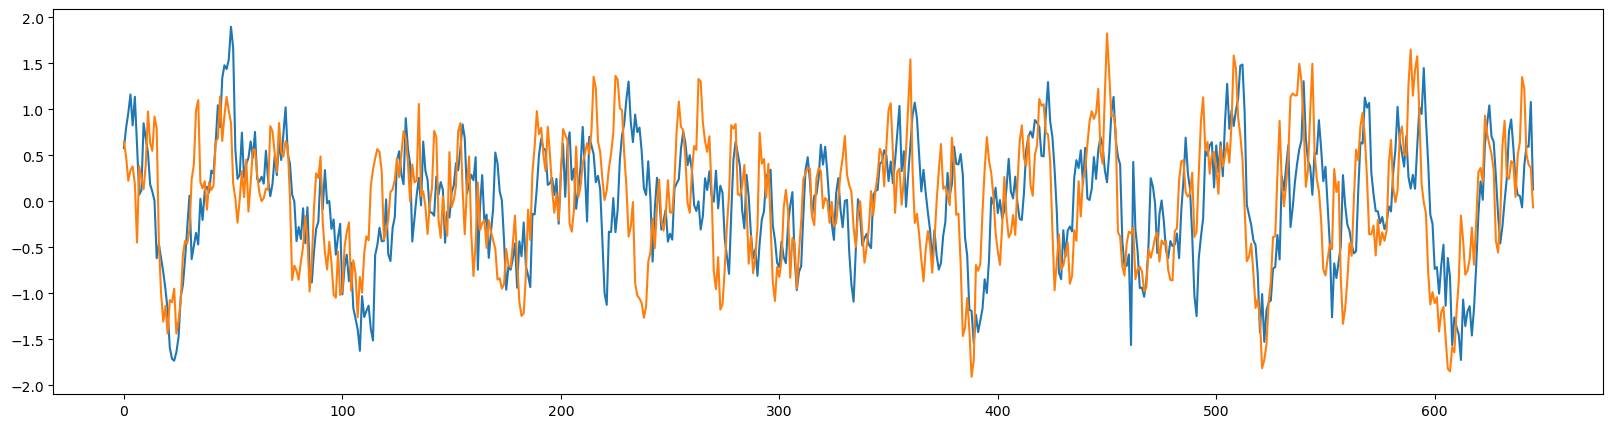

In [50]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(neural_ts['seed'])
plt.plot(neural_ts['target'])
#make plot wider
plt.show()
